In [1]:
## V2 CREATED AFTER 2 BEST TRADERS DIDN'T PERFORM WELL
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.1.0
Default GPU Device: /device:GPU:0


In [2]:
import pandas as pd

full_data = pd.read_csv('result.csv', header=None)
trader_ranks = full_data[full_data.columns[0]]
data = full_data.drop(full_data.columns[0], axis=1)

print(data.head(10))
print(trader_ranks.head(10))


        1   2      3           4           5           6       7           8   \
0   2.2000   0  138.0 -138.000000   69.000000    0.100000  138.10    0.200000   
1   4.6125   0   72.0  570.050000  421.025000  421.025000  136.00  706.050000   
2   5.9250   0   61.0   19.000000  112.000000  112.000000  103.00  122.000000   
3   6.8625   1   97.0    7.937037   88.968519   90.291358   85.00   92.937037   
4   7.6875   0   58.0   36.000000  103.000000  109.000000   85.00  121.000000   
5  11.2500   1   92.0    1.000000   90.000000   90.000000   90.00   91.000000   
6  12.5375   1  136.0    6.666667  103.333333  103.333333  100.00  106.666667   
7  13.2125   1  115.0    5.000000  110.000000  110.000000  108.00  113.000000   
8  13.6625   0  113.0    0.750000  113.625000  113.625000  113.25  114.000000   
9  15.4625   0  112.0    1.000000  112.000000  112.000000  112.00  113.000000   

       9   10  11          12        13          14  
0  2.2000   1   3    0.300000  0.400000  138.200000  


In [3]:
## Normalise data and convert ranks in to weights (using reciprocal function)
def reciprocal(x):
    return float(1/x)

normalised_data=(data-data.min())/(data.max()-data.min())
trader_ranks_frame = trader_ranks.to_frame()
trader_weights = trader_ranks_frame.applymap(reciprocal)

# print(normalised_data.head(10))
# print(trader_weights.head(10))

In [21]:
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import newaxis

validation_split = 0.1
train, validation = train_test_split(normalised_data, test_size=validation_split, shuffle=False)
train_trader_weights, val_trader_weights = train_test_split(trader_weights, test_size=validation_split, shuffle=False)

print(train_trader_weights[0])

train_x = train.loc[:, :13]
train_y = train.loc[:, 14]
val_x = validation.loc[:, :13]
val_y = validation.loc[:, 14]

x_train = train_x.to_numpy()
y_train = train_y.to_numpy()
x_val = val_x.to_numpy()
y_val = val_y.to_numpy()

x_train = x_train[:,:, newaxis]
x_val = x_val[:,:, newaxis]

0          0.031250
1          0.125000
2          0.050000
3          0.023810
4          0.024390
             ...   
4250099    0.125000
4250100    0.058824
4250101    0.250000
4250102    0.023256
4250103    0.040000
Name: 0, Length: 4250104, dtype: float64


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM#, CuDNNLSTM
#from tensorflow.compat.v1.keras.layers import CuDNNLSTM

model = Sequential()
model.add(LSTM(10, input_shape=(x_train.shape[1:]), return_sequences=False))
#model.add(Dropout(0.05))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='relu'))

opt = tf.keras.optimizers.Adam(lr=1.5e-4, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer=opt)

history = model.fit(x_train, y_train, epochs=10, batch_size=1024, validation_data=(x_val, y_val), sample_weight=train_trader_weights[0])


  ...
    to  
  ['...']
Train on 4250104 samples, validate on 472234 samples
Epoch 1/10
4250104/4250104 [==============================] - 33s 8us/sample - loss: 0.0016 - val_loss: 0.0070
Epoch 2/10
4250104/4250104 [==============================] - 30s 7us/sample - loss: 6.2442e-04 - val_loss: 0.0045
Epoch 3/10
4250104/4250104 [==============================] - 30s 7us/sample - loss: 4.3000e-04 - val_loss: 0.0036
Epoch 4/10
4250104/4250104 [==============================] - 34s 8us/sample - loss: 3.4449e-04 - val_loss: 0.0032
Epoch 5/10
4250104/4250104 [==============================] - 32s 8us/sample - loss: 3.0345e-04 - val_loss: 0.0030
Epoch 6/10
4250104/4250104 [==============================] - 31s 7us/sample - loss: 2.8398e-04 - val_loss: 0.0029
Epoch 7/10
4250104/4250104 [==============================] - 39s 9us/sample - loss: 2.7307e-04 - val_loss: 0.0028
Epoch 8/10
4250104/4250104 [==============================] - 33s 8us/sample - loss: 2.6483e-04 - val_loss: 0.0027
Epoch 

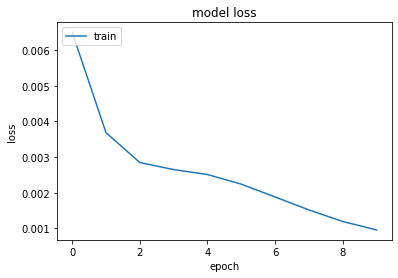

[[0.64067936 0.03125    0.882     ]
 [0.71089059 0.125      0.86      ]
 [0.58541602 0.05       0.53      ]
 [0.44821984 0.02380952 0.42937037]
 [0.41523713 0.02439024 0.35      ]
 [0.42404094 0.03225806 0.41      ]
 [0.58678889 1.         0.56666667]
 [0.61659241 0.02564103 0.63      ]
 [0.63078588 0.0625     0.6325    ]
 [0.61043739 0.11111111 0.62      ]
 [0.62256652 0.33333333 0.62      ]
 [0.50799012 0.09090909 0.52      ]
 [0.54480618 0.04       0.4792037 ]
 [0.46041343 0.04347826 0.46      ]
 [0.57034051 0.05263158 0.61      ]
 [0.65117431 0.03333333 0.64      ]
 [0.39795619 0.01960784 0.41      ]
 [0.37666428 0.1        0.38      ]
 [0.46587855 0.5        0.5       ]
 [0.49959278 0.02777778 0.53466667]
 [0.47231752 0.01785714 0.49      ]
 [0.5093196  0.04166667 0.52633333]
 [0.41268504 0.02777778 0.42      ]
 [0.35449842 0.08333333 0.36      ]
 [0.42903692 0.05882353 0.45      ]
 [0.49131641 0.05263158 0.5       ]
 [0.56176543 0.2        0.59      ]
 [0.37804741 0.03225806 0.42

In [17]:
## Previous loss: loss: 2.1564e-04 - val_loss: 0.0016
## 512, 1e-4, no dropout, no weights = loss: 8.8952e-04 - val_loss: 9.5390e-04
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

train_values = x_train[:100]
print(np.c_[model.predict(train_values), train_trader_weights[:100], y_train[:100]])
test_values = x_val[:100]
print(np.c_[model.predict(test_values), val_trader_weights[:100], y_val[:100]])

In [32]:
model.save('DeepTraderv2.h5')

In [9]:
new_model = tf.keras.models.load_model('DeepTraderv2_no_weights.h5')

new_model.evaluate(x_val,  y_val, verbose=1) 

472234/472234 [==============================] - 67s 141us/sample - loss: 9.5390e-04


0.0009539012649751713

In [22]:
test_arr = np.copy(x_val)
print(test_arr.shape)
print(test_arr[:2, :, :])
np.random.shuffle(test_arr[:,0])
print(x_val[:2, :, :])
print(test_arr[:2, :, :])

(472234, 13, 1)
[[[0.22351224]
  [0.        ]
  [0.22      ]
  [0.14013778]
  [0.16181818]
  [0.15921788]
  [0.74666667]
  [0.116     ]
  [0.00424328]
  [0.        ]
  [0.609375  ]
  [0.70322874]
  [0.13223405]]

 [[0.22511123]
  [0.        ]
  [0.33      ]
  [0.14104776]
  [0.16      ]
  [0.15782123]
  [0.74      ]
  [0.116     ]
  [0.01084394]
  [0.        ]
  [0.609375  ]
  [0.71649077]
  [0.11900353]]]
[[[0.22351224]
  [0.        ]
  [0.22      ]
  [0.14013778]
  [0.16181818]
  [0.15921788]
  [0.74666667]
  [0.116     ]
  [0.00424328]
  [0.        ]
  [0.609375  ]
  [0.70322874]
  [0.13223405]]

 [[0.22511123]
  [0.        ]
  [0.33      ]
  [0.14104776]
  [0.16      ]
  [0.15782123]
  [0.74      ]
  [0.116     ]
  [0.01084394]
  [0.        ]
  [0.609375  ]
  [0.71649077]
  [0.11900353]]]
[[[0.98991935]
  [0.        ]
  [0.22      ]
  [0.14013778]
  [0.16181818]
  [0.15921788]
  [0.74666667]
  [0.116     ]
  [0.00424328]
  [0.        ]
  [0.609375  ]
  [0.70322874]
  [0.13223405]]
